# Evaluating definite integrals using `TaylorIntegration.jl`

The aim of this example is to show that we can evaluate definite integrals of the form 

$$
I(x) = \int_{x_0}^xf(t)\mathrm{d} t
$$

for a large class of differentiable integrand functions $f$, to within machine epsilon precision, using `TaylorIntegration.jl`. The trick is to translate the definite integral problem to an initial value problem for an explicit ODE, thanks to the fundamental theorem of calculus.

## Case study: $I(x)=\frac{2}{\sqrt{\pi}}\int_0^x \exp(-[g(t)]^2) dt$

## 1. $g(t)=t$

In general, if we want to evaluate the [__error function__](https://en.wikipedia.org/wiki/Error_function) integral $I(x)=\frac{2}{\sqrt{\pi}}\int_0^x \exp(-[g(t)]^2) dt$ using `TaylorIntegration.jl`, then we may proceed as follows. Essentially: first define a suitable ODE system equivalent to the definite integral problem at hand, and then integrate it. 

Indeed, by the fundamental theorem of calculus we have

$$
I'(x) =\frac{2}{\sqrt{\pi}}\exp(-[g(x)]^2)
$$


where the prime $'$ denotes differentiation with respect to $x$. Therefore, we reinterpret $I(x)$ as the solution of the initial value problem defined by the ODE

$$
\frac{dI}{dx} = \frac{2}{\sqrt{\pi}}\exp(-[g(x)]^2)
$$

subject to the initial condition $I(0)=0$. Indeed, if we differentiate both sides of the last equation:

$$
\frac{d^2I}{dx^2} = \frac{2}{\sqrt{\pi}}(-2g(x)g'(x))\exp(-[g(x)]^2) = -2g(x)g'(x)\frac{dI}{dx}
$$

We now define $J(x)=\frac{dI}{dx}$. Then, we can write the following ODE system for $I$ and $J$:

$$
\begin{align}
    \begin{split}
        \frac{dI}{dx} &= J \\
        \frac{dJ}{dx} &= -2g(x)g'(x)J \\
        \frac{dx}{dx} &= 1
    \end{split}
\end{align}
$$

This is the ODE system that we will integrate in order to evaluate $I(x)$. We need the last equation, $dx/dx = 1$, since we need to evaluate the function $g$ at several points $x$ (here, $x$ is the independent variable). The initial conditions are

$$
\begin{align}
    \begin{split}
        I(0) &= 0 \\
        J(0) &= \frac{2}{\sqrt{\pi}}\exp(-[g(0)]^2) \\
        x(0) &= 0
    \end{split}
\end{align}
$$

The only packages that we need to load are:

In [1]:
using TaylorIntegration, Plots
pyplot()

Plots.PyPlotBackend()

This is the ODE representation of the integral we are interested in, $I(x)$:

In [2]:
g(x) = x
g′(x) = one(x) # = TaylorSeries.derivative(g(x)) ?

function f!(t, x, xdot)
    xdot[1] = one(x[1])
    xdot[2] = x[3]
    xdot[3] = -2g(x[1])*g′(x[1])*x[3]
end

f! (generic function with 1 method)

The parameters we will use for the Taylor integration are:

In [3]:
x0 = 0.0 #the initial value of the independent variable; in this case, x
xmax = 10.0 #the final value of the independent variable; in this case, x
I0 = [x0, 0.0, 2exp(-g(0.0)^2)/sqrt(pi)] #the initial condition for I, J, x
order = 25 #the order of the Taylor expansions
abstol = 1e-20 #the absolute local error tolerance

1.0e-20

The initial conditions are:

In [4]:
I0

3-element Array{Float64,1}:
 0.0    
 0.0    
 1.12838

Then, we proceed to integrate:

In [5]:
@time xv, Iv = taylorinteg(f!, I0, x0, xmax, order, abstol, maxsteps=5000);

  0.296307 seconds (230.47 k allocations: 10.668 MB, 2.41% gc time)


The final $t$, and $x$ values are (remember that the first column of `Iv` corresponds to the independent variable):

In [6]:
xv[end,1], Iv[end,2]

(10.0,1.0000000000000002)

It seems that the integration has already converged. For clarity, let's print `Iv`:

In [7]:
Iv

21×3 SubArray{Float64,2,Array{Float64,2},Tuple{UnitRange{Int64},Colon},false}:
  0.0       0.0        1.12838    
  0.335863  0.3652     1.00801    
  0.677487  0.661994   0.713048   
  1.0449    0.860516   0.378689   
  1.39745   0.951878   0.160082   
  1.74774   0.986552   0.0531935  
  2.10707   0.997116   0.0133139  
  2.49032   0.999571   0.00228613 
  2.897     0.999958   0.000255619
  3.30298   0.999997   2.06267e-5 
  3.72398   1.0        1.07065e-6 
  4.17196   1.0        3.115e-8   
  4.66204   1.0        4.10408e-10
  5.22472   1.0        1.57473e-12
  5.85946   1.0        1.38589e-15
  6.55473   1.0        2.47846e-19
  7.3602    1.0       -3.05793e-22
  8.24791   1.0        9.11964e-22
  8.9768    1.0       -9.84788e-22
  9.63125   1.0        1.04456e-21
 10.0       1.0        7.46312e-25

How does $I(x)$ look as a function of $x$?


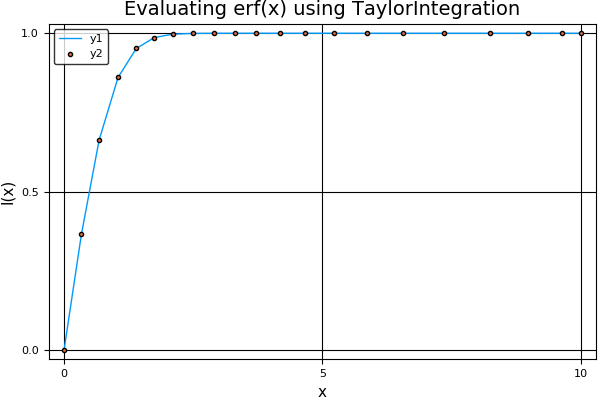

sys:1: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


In [8]:
plot(

xv, Iv[:,2],
xaxis = "x",
yaxis = "I(x)",
title = "Evaluating erf(x) using TaylorIntegration"

)

scatter!(xv, Iv[:,2], ms=3.0)

Looks great; but, how do these values actually compare to $\mathrm{erf}$? Well, let's plot the absolute difference between our values for $I(x)$ and $\mathrm{erf}(x)$, as a function of $x$:


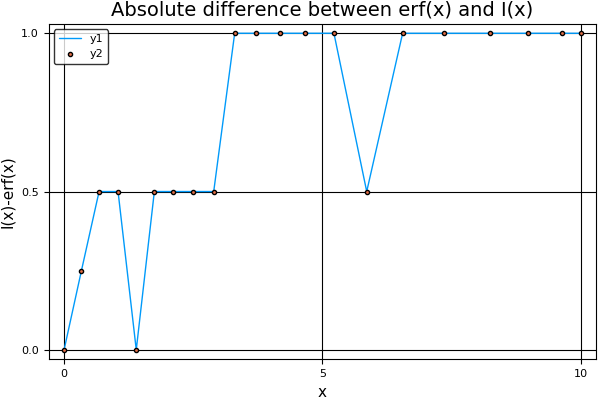

In [9]:
plot(

xv, (Iv[:,2]-erf(xv))/eps(),
xaxis = "x",
yaxis = "I(x)-erf(x)",
title = "Absolute difference between erf(x) and I(x)"

)

scatter!(xv, (Iv[:,2]-erf(xv))/eps(), ms=3.0)

__The error is at most `eps()` at each time step!!!!__

## 1. $g(t)=\cos{t}$

When $g(x)=\cos{x}$, if we ignore the factor $\frac{2}{\sqrt{\pi}}$, then the definite integral reduces to

$$
I(x)=\int_0^x \exp(-\cos^2(t)) dt
$$

And
$$
g'(x)=\sin(x)
$$

We end up with the following system:
$$
\begin{align}
    \begin{split}
        \frac{dI}{dx} &= J \\
        \frac{dJ}{dx} &= 2\sin(x)\cos(x)J \\
        \frac{dx}{dx} &= 1
    \end{split}
\end{align}
$$

In [10]:
G(x) = cos(x)
G′(x) = -sin(x) # = TaylorSeries.derivative(g(x)) ?

function f2!(t, x, xdot)
    xdot[1] = one(x[1])
    xdot[2] = x[3]
    xdot[3] = -2G(x[1])*G′(x[1])*x[3]
end

f2! (generic function with 1 method)

The initial conditions are $I(0)=0$, $J(0)=\exp(-[g(0)]^2)=e^{-1}$ and $x(0)=0$.

In [11]:
x02 = 0.0 #the initial value of the independent variable; in this case, x
xmax2 = 10.0 #the final value of the independent variable; in this case, x
I02 = [x02, 0.0, exp(-G(0.0)^2)] #the initial condition for I, J, x
order2 = 25 #the order of the Taylor expansions
abstol2 = 1e-20 #the absolute local error tolerance

1.0e-20

In [12]:
I02

3-element Array{Float64,1}:
 0.0     
 0.0     
 0.367879

Next, we perform the Taylor integration:

In [13]:
@time xv2, Iv2 = taylorinteg(f2!, I02, x02, xmax2, order2, abstol2, maxsteps=5000);

  0.086718 seconds (66.10 k allocations: 4.645 MB, 17.59% gc time)


In this case, we don't have an explicit expression to evaluate the definite integral! Nevertheless, we can plot $I(x)$ as a function of $x$:


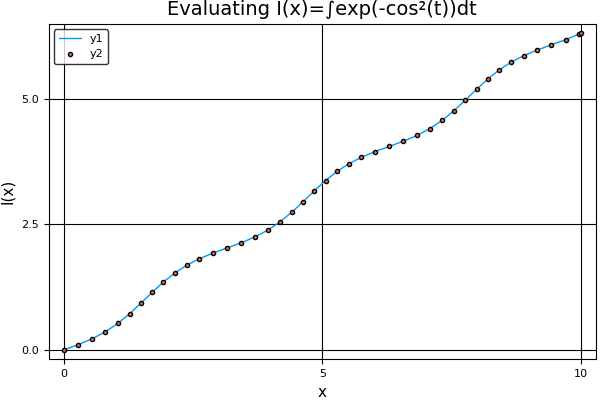

In [14]:
plot(

xv2, Iv2[:,2],
xaxis = "x",
yaxis = "I(x)",
title = "Evaluating I(x)=∫exp(-cos²(t))dt"

)

scatter!(xv2, Iv2[:,2], ms=3.0)

Is this the behavior we would expect of $I(x)$? In order to get an idea of how does the integral of $f(x)=\exp(-\cos^2(x))$ behaves, we plot $f$ as a function of $x$:

In [15]:
xlin = linspace(0.0, 10.0, 100)
Ilin = exp(-cos(xlin).^2);


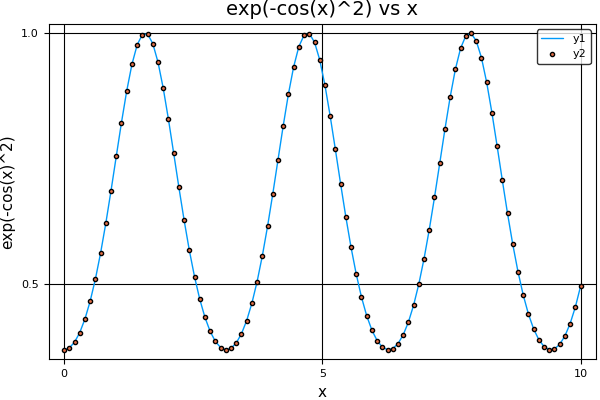

In [16]:
plot(

xlin, Ilin,
xaxis = "x",
yaxis = "exp(-cos(x)^2)",
title = "exp(-cos(x)^2) vs x"

)

scatter!(xlin, Ilin, ms=3.0)

Indeed, since $\cos^2(x)$ oscillates between 0 and 1, $\exp(-\cos^2(x))$ oscillates between 1 and $e^{-1}$ ad infinitum. So yes, we would expect its definite integral to diverge linearly as $x\to\infty$.